In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

from PIL import Image
from numpy import asarray
import os
import cv2
from PIL import Image, ImageOps

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0_4eztms
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-0_4eztms
  Resolved https://github.com/tensorflow/docs to commit a89b900f18bb647a8a5cba40997eacbe801c0fc0
  Preparing metadata (setup.py) ... done


In [ ]:
def isolate_emoji(image):
  image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
  # Read images
  image = cv2.GaussianBlur(image, (7, 7), 0)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Image outline (Image Contours)
  ret, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
  contours1, hierarchy1 = cv2.findContours(binary_image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE,
  offset=(0, 0))


  contours = max(contours1, key = cv2.contourArea).reshape(1, -1, 2)
  fill_color = [255, 255, 255] # any BGR color value to fill with
  mask_value = 255  
  stencil = np.zeros(image.shape).astype(image.dtype)
  stencil  = np.zeros(image.shape[:-1]).astype(np.uint8)
  cv2.fillPoly(stencil, contours, mask_value)
  sel = stencil != mask_value
  image[sel] = fill_color
  plt.imshow(image)
  plt.show()
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  im_pil = Image.fromarray(img)
  return im_pil

In [ ]:
train_images = []

for filename in os.listdir("/content/drive/MyDrive/Colab Notebooks/Computer Vision/Emojis/Face Emojis"):
    if filename.endswith("jpg"): 
      #img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Computer Vision/cards/Images" + "/" + filename)
      img = Image.open("/content/drive/MyDrive/Colab Notebooks/Computer Vision/Emojis/Face Emojis" + "/" + filename).convert('RGBA')
      #img = img.convert('RGB')
      #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #img = isolate_emoji(img)

      img = ImageOps.grayscale(img)
      img = np.array(img)
      train_images.append(img)

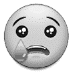

In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Computer Vision/Emojis/Face Emojis" + "/emoji (509).jpg").convert('RGBA')
#img = img.convert('RGB')
#img = isolate_emoji(img)
img = ImageOps.grayscale(img)
img
#img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
#img = ImageOps.grayscale(img)


In [ ]:
train_images = np.asarray(train_images).astype('float32')
train_images.shape

(574, 72, 72)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 72, 72, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 574
BATCH_SIZE = 20

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#GENERATOR
-----------------------------------------------------------

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(18*18*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((18, 18, 256)))
    assert model.output_shape == (None, 18, 18, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 18, 18, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 36, 36, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 72, 72, 1)

    return model

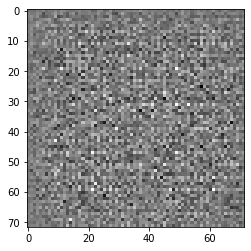

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#DISCRIMINATOR
------------------------------------------------

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[72, 72, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0001716]], shape=(1, 1), dtype=float32)


#LOSS AND OPTIMIZERS
-------------------------------------------------------

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#TRAINING LOOP
---------------------------------------------

In [ ]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16


# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(16, 16))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()




#TRAINING
--------------------------------------------------------

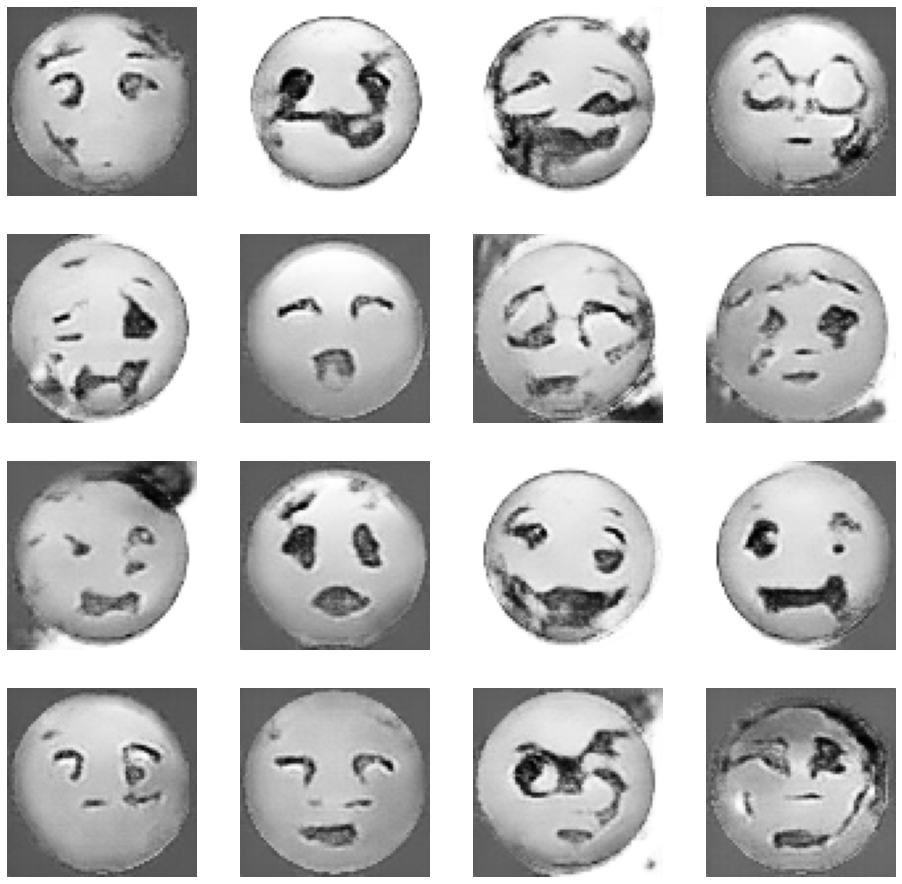

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number


def display_image(epoch_no, i):

  return PIL.Image.open('image_at_epoch_{0}_at{1}.png'.format(epoch_no, i))

In [ ]:
from google.colab import files   # file download

anim_file = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
files.download('dcgan.gif')